In [1]:
from data_utils import Utility

In [2]:
val_images, val_questions, val_answers = Utility.read_dataset("Valid")
train_images, train_questions, train_answers = Utility.read_dataset("Train")
#test_images, test_questions = read_dataset("Test")

Valid data size= 500
Train data size= 5413


Image name : dataset/VQAMed2018Train/VQAMed2018Train-images/AIAN-14-313-g002.jpg
Question   : where does axial section mri abdomen show hypoechoic mass ?
Answer     : in distal pancreas


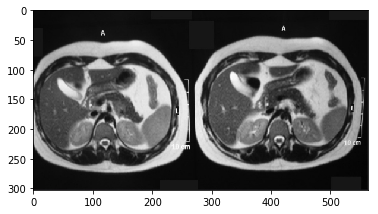

In [3]:
id =1
Utility.show_image(id, train_images, train_questions, train_answers )

<hr style:"color: black">


<link href="https://fonts.googleapis.com/css?family=Bitter|Bree+Serif|Patua+One" rel="stylesheet">
<h1 style="font-family: "Patua One", serif; text-align: center;"> Visual Question Answering Demo in Python Notebook</h1>
<hr>
<img src="https://blog.keras.io/img/keras-tensorflow-logo.jpg"/>


##### Load libraries

In [4]:
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Dropout, Reshape, Flatten, merge
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Model
from sklearn.cross_validation import train_test_split
import os
import sys

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


##### Configs

In [5]:
DATA_DIR = "dataset/"
MODEL_DIR = "saved_models/"
WORD2VEC_BIN = "dataset/vqa_vec150.bin"
WORD2VEC_EMBED_SIZE = 150 #300

QA_TRAIN_FILE = DATA_DIR+"VQAMed2018Train/VQAMed2018Train-QA.csv"
QA_TEST_FILE = DATA_DIR+"VQAMed2018Valid/VQAMed2018Valid-QA.csv"

QA_EMBED_SIZE = 64
BATCH_SIZE = 128
NBR_EPOCHS = 20

##### Load training data

In [30]:
print("Loading and formatting training data...")
train_images, train_questions, train_answers = Utility.read_dataset("Train")

qapairs = [[Utility.clean(q).split(), Utility.clean(a).split()] for q,a in zip(train_questions, train_answers)]

question_maxlen = max([len(qapair[0]) for qapair in qapairs])
answer_maxlen = max([len(qapair[1]) for qapair in qapairs])
print("train question maxlen:",question_maxlen,",train answer_maxlen", answer_maxlen)

Loading and formatting training data...
Train data size= 5413
train question maxlen: 29 ,train answer_maxlen 26


##### Load validation data

In [31]:
print("Loading and formatting validation data...")
val_images, val_questions, val_answers = Utility.read_dataset("Valid")

tqapairs = [[Utility.clean(q).split(), Utility.clean(a).split()] for q,a in zip(val_questions, val_answers)]

tq_maxlen = max([len(qapair[0]) for qapair in tqapairs])
ta_maxlen = max([len(qapair[1]) for qapair in tqapairs])
print("test question maxlen:",tq_maxlen,", test answer_maxlen", ta_maxlen)

Loading and formatting validation data...
Valid data size= 500
test question maxlen: 16 , test answer_maxlen 14


In [32]:
seq_maxlen = max([question_maxlen, answer_maxlen, tq_maxlen, ta_maxlen])

In [ ]:
# Load FastText Model and create lookup embeddings
print("Load embeddings from: "+vectors)
all_model = FastText()
all_model = all_model.load_fasttext_format(vectors)
all_word_vectors = all_model.wv
embeddings = np.array([all_model[k] for k in all_word_vectors.vocab.keys()])

# Add PAD, EOS and UNK to the word embeddings
pre = np.concatenate((np.ones(emb_size)*-1, np.ones(emb_size), np.zeros(emb_size)))
all_vocab_size = len(all_word_vectors.vocab)
embeddings = np.reshape(np.insert(embeddings, 0, pre), (all_vocab_size+3, emb_size))
wor2tok = {'PAD': 0, 'EOS': 1, 'UNK': 2}
tok2wor = {0: 'PAD', 1: 'EOS', 2: 'UNK'}
ind = 3
for k in all_word_vectors.vocab.keys():
    wor2tok[k] = ind
    tok2wor[ind] = k
    ind += 1
